# Demo the Arbitrageur Agent Logic

This notebook:

1. Fetches the latest crvusd contract data into Python objects using `crvusdsim`.
2. Fetches prices and `ExternalMarket`s from the `baseline` scenario.
3. Instantiates an Arbitrageur agent.
4. Checks if there are profitable arbitrages and performs them.

TODO describe the arbitrage logic in detail.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.sim.scenario import Scenario
import networkx as nx
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# Generate markets and prices
scenario = Scenario("baseline")
sample = scenario.pricepaths[0]
scenario.prepare_for_run()  # Set block timestamps
scenario.prepare_for_trades(sample)  # Set External Market Price

# Unpack
markets = scenario.markets
pool = scenario.llamma
stableswap_pools = scenario.stableswap_pools
cycles = scenario.cycles
arbitrageur = scenario.arbitrageur

# Display available arbitrage cycles
cycles

In [ ]:
def simple_name(pool):
    if "External Market" in pool.name:
        return pool.name.replace("External Market", "EM")
    if "Curve.fi Factory Plain Pool:" in pool.name:
        return pool.name.replace("Curve.fi Factory Plain Pool:", "SS")
    if "Curve.fi Stablecoin" in pool.name:
        return pool.name.replace("Curve.fi Stablecoin", "Stable")


graph_hashmap = {
    simple_name(k): [simple_name(v) for v in vs]
    for k, vs in scenario.graph.graph.items()
}

G = nx.Graph()
for node, edges in graph_hashmap.items():
    for edge in edges:
        G.add_edge(node, edge)

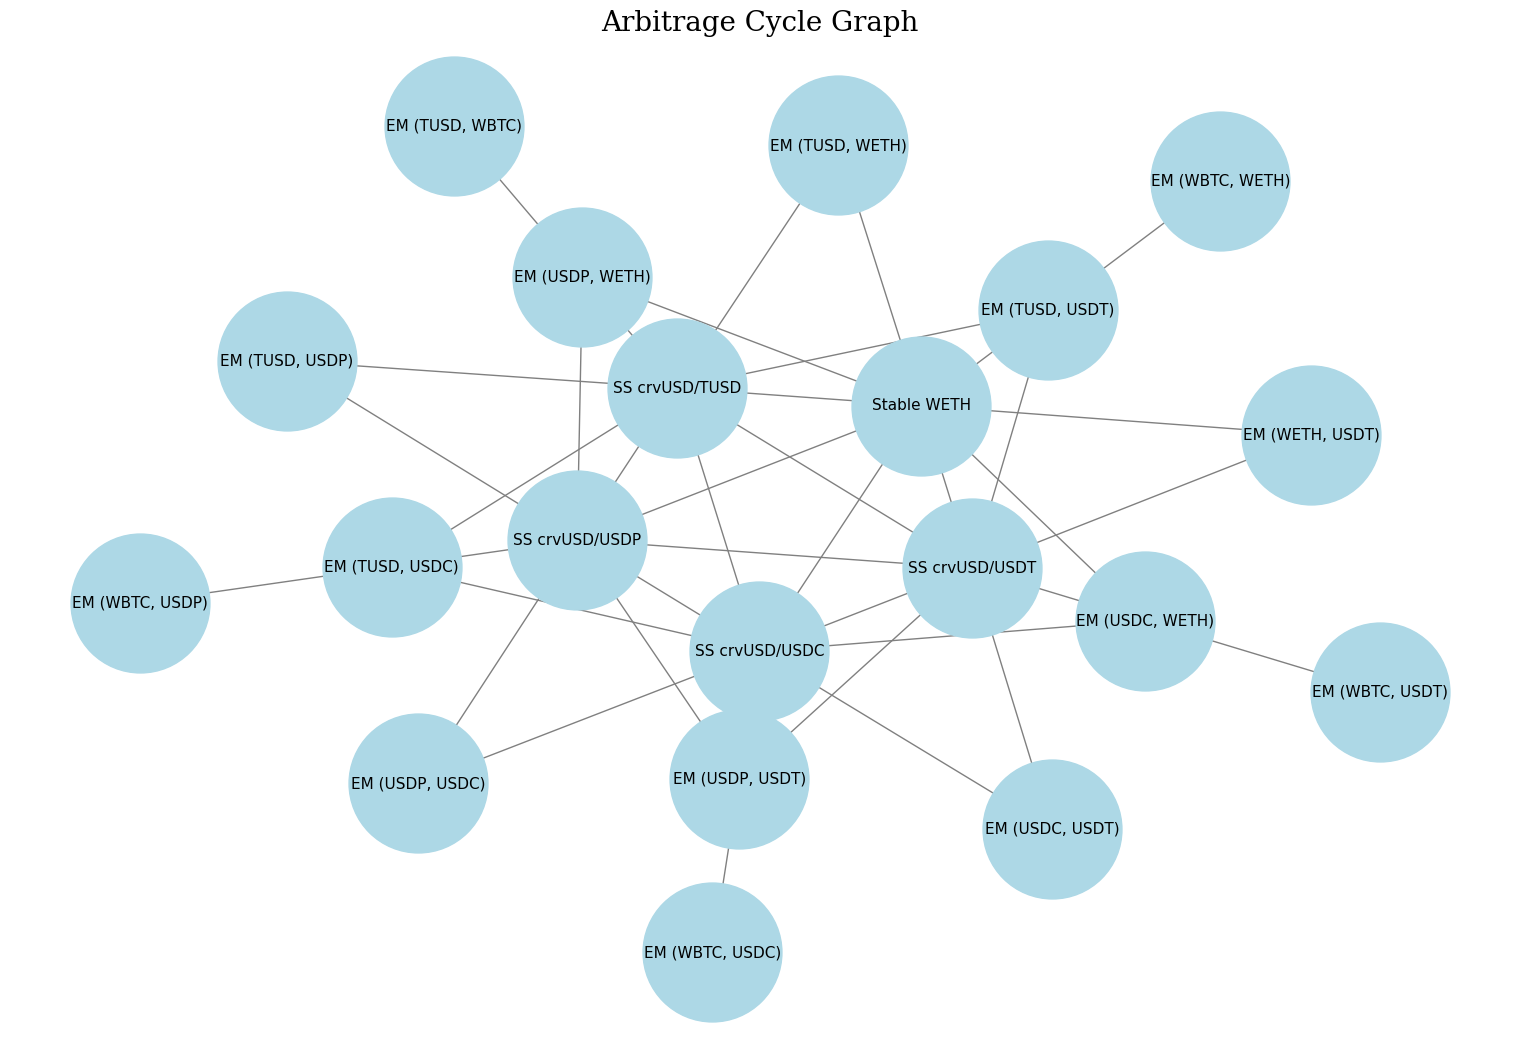

In [ ]:
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    edge_color="gray",
    font_size=11,
    node_size=10000,
)
plt.title("Arbitrage Cycle Graph", size=20)
plt.show()

# Show that arbitrage cycle optimization finds the most profitable arbitrage

The `cycle.optimize()` method will find the `amt_in` to the first trade in a `Cycle` that maximizes the `Cycle`'s profit. We plot `cycle.optimize()` against the profits from a simple `np.linspace` to show it converges to the maximum. The dataframe below also tells the same story.

In [ ]:
df = pd.DataFrame(
    columns=["amt_optimize", "amt_linspace", "profit_optimize", "profit_linspace"]
)

for i, cycle in enumerate(cycles):
    try:
        # This is orders of magnitude slower than `optimize`
        trade = cycle.trades[0]
        high = trade.pool.get_max_trade_size(trade.i, trade.j)
        amts = np.linspace(0, high, 1000)
        amts = [int(amt) for amt in amts]
        profits = [cycle.populate(amt) for amt in amts]

        best_amt_linspace = int(amts[np.argmax(profits)])
        best_profit_linspace = int(max(profits))

        cycle.optimize()

        df.loc[i] = [
            cycle.trades[0].amt,
            best_amt_linspace,
            cycle.expected_profit,
            best_profit_linspace,
        ]

    except Exception as e:
        print(f"Cycle {i} failed to optimize: {e}")

df["profit_linspace"] = df["profit_linspace"].astype(float)
df["profit_optimize"] = df["profit_optimize"].astype(float)
df = df.round(3)
df

[INFO][02:50:02][src.trades.cycle]-960442: No liquidity for Cycle(Trades: [Swap(pool=Curve.fi Stablecoin WETH, in=WETH, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=crvUSD, out=TUSD, amt=0), Swap(pool=External Market (TUSD, WETH), in=TrueUSD, out=Wrapped Ether, amt=0)], Expected Profit: 0.0).
[INFO][02:50:02][src.trades.cycle]-960442: No liquidity for Cycle(Trades: [Swap(pool=Curve.fi Stablecoin WETH, in=WETH, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDP, in=crvUSD, out=USDP, amt=0), Swap(pool=External Market (USDP, WETH), in=Pax Dollar, out=Wrapped Ether, amt=0)], Expected Profit: 0.0).
[INFO][02:50:02][src.trades.cycle]-960442: No liquidity for Cycle(Trades: [Swap(pool=Curve.fi Stablecoin WETH, in=WETH, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=crvUSD, out=USDC, amt=0), Swap(pool=External Market (USDC, WETH), in=USD Coin, out=Wrapped Ether, amt=0)], Expected Profit: 0.0).
[INFO][02:50:02][src.tra

,amt_optimize,amt_linspace,profit_optimize,profit_linspace
0,667.0,0.0,-0.000,0.0
1,50079315191932.0,0.0,-0.000,0.0
2,237371327768528.0,0.0,-0.000,0.0
3,1281868765502923174051840,1282880734058251733172224,26004.889,26004.0
4,245545752526923463917568,245216511735086811447296,120.577,120.0
5,579221604094038.0,0.0,-0.000,0.0
6,2071752264351094.0,0.0,-0.000,0.0
7,1527749885957339919417344,1528436898387628556025856,30250.970,30250.0
8,928925826849.0,920671863625.0,1076.673,1076.0
9,306395079875.0,306890621208.0,160.305,160.0


Best amount linspace: 1906481104018
Best profit linspace: 35035.221161
Best amount optimize: 1910713531925
Best profit optimize: 35035.389479


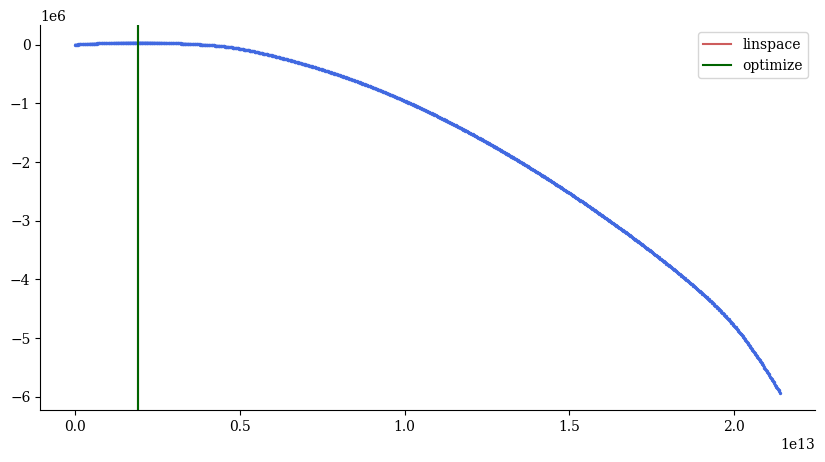

In [ ]:
# TODO In theory, this curve should be perfectly smooth and convex.
# However, it has a few bumps. These bumps don't detract from the
# convexity, but they do make it less smooth. The reason is that
# the slippage curves we set for `ExternalMarket`s are not perfectly
# smooth: they have small regions where slippage is constant despite
# increasing trade size. We discuss this more in `demo_slippage_curves.ipynb`,
# but it has to do with the fact that we use an IsotonicRegression to
# fit the slippage curve, whereas the "true" relationship is moreso a
# CenteredIsotonicRegression. This is a known issue, and we are working on it.

i = 15
cycle = cycles[i]

trade = cycle.trades[0]
high = trade.pool.get_max_trade_size(trade.i, trade.j)
amts = np.linspace(1, high, 1000)
amts = [int(amt) for amt in amts]
profits = [cycle.populate(amt) for amt in amts]

best_amt_linspace = amts[np.argmax(profits)]
best_profit_linspace = max(profits)

# compare
cycle.optimize()
best_amt_optimize = cycle.trades[0].amt
best_profit_optimize = cycle.expected_profit

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(amts, profits, color="royalblue", s=2)
ax.plot(amts, profits, color="royalblue")
ax.axvline(best_amt_linspace, color="indianred", label="linspace")
ax.axvline(best_amt_optimize, color="darkgreen", label="optimize")

# NOTE Uncomment to zoom into optimal region
# diff = abs(best_amt_optimize - best_amt_linspace)
# xlims = (float(min(best_amt_optimize, best_amt_linspace) - diff), float(max(best_amt_optimize, best_amt_linspace) + diff))
# tmp = [p for p, a in zip(profits, amts) if xlims[0] < a < xlims[1]]
# ylims = min(tmp), max(tmp)
# ax.set_xlim(*xlims)
# ax.set_ylim(*ylims)

ax.legend()

print(f"Best amount linspace: {best_amt_linspace}")
print(f"Best profit linspace: {best_profit_linspace}")
print(f"Best amount optimize: {best_amt_optimize}")
print(f"Best profit optimize: {best_profit_optimize}")

# Analyzing arbitrages

Now we show our arbitrage agent arbitraging all pools until there is no profitable arbitrage left.

In [ ]:
profit, count = arbitrageur.arbitrage(cycles, sample)
print(f"Performed {count} arbitrages for a profit of {profit} USD.")

[INFO][02:50:18][src.trades.cycle]-960442: No liquidity for Cycle(Trades: [Swap(pool=Curve.fi Stablecoin WETH, in=WETH, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=crvUSD, out=TUSD, amt=0), Swap(pool=External Market (TUSD, WETH), in=TrueUSD, out=Wrapped Ether, amt=0)], Expected Profit: 0.0).
[INFO][02:50:18][src.trades.cycle]-960442: No liquidity for Cycle(Trades: [Swap(pool=Curve.fi Stablecoin WETH, in=WETH, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDP, in=crvUSD, out=USDP, amt=0), Swap(pool=External Market (USDP, WETH), in=Pax Dollar, out=Wrapped Ether, amt=0)], Expected Profit: 0.0).
[INFO][02:50:18][src.trades.cycle]-960442: No liquidity for Cycle(Trades: [Swap(pool=Curve.fi Stablecoin WETH, in=WETH, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=crvUSD, out=USDC, amt=0), Swap(pool=External Market (USDC, WETH), in=USD Coin, out=Wrapped Ether, amt=0)], Expected Profit: 0.0).
[INFO][02:50:18][src.tra

[INFO][02:50:18][src.trades.cycle]-960442: Executing trade Swap(pool=External Market (TUSD, USDC), in=TrueUSD, out=USD Coin, amt=764319440798719550639638).
[INFO][02:50:18][src.agents.arbitrageur]-960442: Executing arbitrage: Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=crvUSD, amt=104993099072), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDP, in=crvUSD, out=USDP, amt=104997700624182148608446), Swap(pool=External Market (USDP, USDC), in=Pax Dollar, out=USD Coin, amt=104903681209835613037409)], Expected Profit: 15.485819).
[INFO][02:50:18][src.trades.cycle]-960442: Executing cycle Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=crvUSD, amt=104993099072), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDP, in=crvUSD, out=USDP, amt=104997700624182148608446), Swap(pool=External Market (USDP, USDC), in=Pax Dollar, out=USD Coin, amt=104903681209835613037409)], Expected Profit: 15.485819).
[INFO][02:50:18][src.trades.cycle

Performed 4 arbitrages for a profit of 37734.471827 USD.


### A Quant Might Ask

Why is there such a profitable arbitrage opportunity? Does that not violate the no-arbitrage condition?

It does. But the answer is: crvUSD pool snapshots and stableswap pool snapshots are taken at different times. This means the pools are mispriced by construction! The LLAMMA price is based on the "oracle price" and the bands snapshots taken by the subgraph. The stableswap prices are based on a separate snapshot taken by a separate subgraph service. Finally, the External Markets are all set to the "current" prices from Coingecko. 

For our risk simulations, this means that our "setup" period should include an initial round of arbitrages to equilibrate all pool prices.

In [ ]:
from src.trades.cycle import _optimize_mem

_optimize_mem.cache_info()

CacheInfo(hits=26, misses=96, maxsize=1000, currsize=96)